In [54]:
import numpy as np
import pandas as pd
import matplotlib as plt
import geopandas as gpd # conda install geopandas
import shapely
import folium # conda install -c conda-forge folium
import json
import pickle
import geopy
from geopy.extra.rate_limiter import RateLimiter

In [100]:
data = pd.read_csv('data/food-inspections.csv').drop(['City', 'State', "Historical Wards 2003-2015", "Zip Codes", "Community Areas", "Census Tracts", "Wards", "Location"], axis=1)

In [106]:
locator = geopy.geocoders.Nominatim(user_agent='myGeocoder')
data_wo_latlong = data[data['Latitude'].apply(np.isnan)].groupby("DBA Name").first()
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)
lats = pd.Series(index=data_wo_latlong.index)
longs = pd.Series(index=data_wo_latlong.index)
for name, address in list(zip(data_wo_latlong.index, data_wo_latlong['Address'])):
    location = geocode(address)
    if location is not None:
        lats[name] = location.latitude
        longs[name] = location.longitude
    else:
        print('Did not find location for address: ' + address)

for name, lat, long in zip(lats.index, lats, longs):
    data['Latitude'] = np.where(data['DBA Name'] == name, lat, data['Latitude'])
    data['Longitude'] = np.where(data['DBA Name'] == name, long, data['Longitude'])


Did not find location for address: 2653 N WASTENAW AVE BLDG 
Did not find location for address: 239 GOLF MILL CENTER STE 322
Did not find location for address: 4943 W 63RD ST /SIDE DRIVE
Did not find location for address:  
Did not find location for address: 2911 W W 47TH ST 
Did not find location for address: 7141 S Morgan (1000W) ST 
Did not find location for address: 2 N RIVERSIDEPLZ PLZ 
Did not find location for address: 5516 S Maplewood (2532W) AVE 
Did not find location for address: 13100 S Doty (1030E) 
Did not find location for address: 405 N Wasbash AVE 
Did not find location for address: 4934 S Wabash (45E) (C/Shabazz) 
Did not find location for address: 5235-5237 N BROARDWAY 
Did not find location for address: 6650 S Ellis (1000E) AVE 
Did not find location for address: 5415 S Union(700W) AVE 
Did not find location for address: 4934 S Wabash (45E) BLDG 
Did not find location for address: 2920 S WENWORTH STE 2
Did not find location for address:  
Did not find location for ad

In [107]:
data[data['Latitude'].apply(np.isnan)]

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude
283,2315863,CHARTWELLS,ROWE MIDDLE SCHOOL,2549769.0,CHARTER SCHOOL,Risk 1 (High),1434 W AUGUSTA BLVD,60642.0,2019-10-15T00:00:00.000,Canvass,Fail,2. CITY OF CHICAGO FOOD SERVICE SANITATION CER...,NaN,NaN
825,2313087,CAMINO A LA SALUD,CAMINO A LA SALUD,2694282.0,Restaurant,Risk 2 (Medium),4237 W 63RD ST,60629.0,2019-09-30T00:00:00.000,License,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",NaN,NaN
1317,2312470,Carson (Old),Carson (Old),22601.0,School,Risk 1 (High),5516 S Maplewood (2532W) AVE,60629.0,2019-09-18T00:00:00.000,Canvass Re-Inspection,Pass,"55. PHYSICAL FACILITIES INSTALLED, MAINTAINED ...",NaN,NaN
1646,2312072,Carson (Old),Carson (Old),22601.0,School,Risk 1 (High),5516 S Maplewood (2532W) AVE,60629.0,2019-09-11T00:00:00.000,Canvass,Fail,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,NaN,NaN
2274,2311346,PARK MANOR,NaN,2630936.0,Children's Services Facility,Risk 1 (High),50 W 71ST ST,60621.0,2019-08-27T00:00:00.000,License,Fail,2. CITY OF CHICAGO FOOD SERVICE SANITATION CER...,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194451,67865,GUGGENHEIM ELEMENTARY,GUGGENHEIM ELEMENTARY,26311.0,School,Risk 1 (High),7141 S Morgan (1000W) ST,60621.0,2010-01-13T00:00:00.000,Canvass,Fail,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,NaN,NaN
194538,67840,TONTI ELEMENTARY,TONTI ELEMENTARY,25631.0,School,Risk 1 (High),5815 S Homan (3400W) AVE,60629.0,2010-01-12T00:00:00.000,Canvass,Pass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",NaN,NaN
194713,67788,Carson (Old),Carson (Old),22601.0,School,Risk 1 (High),5516 S Maplewood (2532W) AVE,60629.0,2010-01-07T00:00:00.000,Canvass,Pass,"30. FOOD IN ORIGINAL CONTAINER, PROPERLY LABEL...",NaN,NaN
194725,154224,CHARTWELLS,CHARTWELLS,1943637.0,Restaurant,Risk 2 (Medium),1110 W BELDEN AVE,60614.0,2010-01-07T00:00:00.000,Canvass,Pass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,NaN,NaN


In [51]:
g_data = gpd.GeoDataFrame(data)
g_data = g_data.set_geometry([shapely.geometry.Point(x, y) for x, y in zip(data.Longitude, data.Latitude)])
# data = data.sort_values(by='DBA Name')
# data.loc[data['Zip'].apply(np.isnan)]
g_data.head()
# g_data[g_data['Address'] == None]

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,geometry
0,2320509,TAQUERIA EL DORADO,TAQUERIA EL DORADO,2694960.0,Restaurant,Risk 1 (High),2114 W LAWRENCE AVE,60625.0,2019-10-25T00:00:00.000,License Re-Inspection,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.968820,-87.682292,POINT (-87.6822915036914 41.96881972356839)
1,2320519,SALAM RESTAURANT,SALAM RESTAURANT,2002822.0,Restaurant,Risk 1 (High),4634-4636 N KEDZIE AVE,60625.0,2019-10-25T00:00:00.000,Complaint Re-Inspection,Pass,NaN,41.965719,-87.708538,POINT (-87.70853756167853 41.96571901742301)
2,2320421,THE NEW GRACE RESTAURANT,THE NEW GRACE RESTAURANT,2698310.0,Restaurant,Risk 1 (High),4409 N BROADWAY,60640.0,2019-10-24T00:00:00.000,License,Not Ready,NaN,41.962104,-87.655204,POINT (-87.65520382960335 41.96210413223746)
3,2320368,GADS HILL CHILD CARE CENTER,GADS HILL CHILD CARE CENTER,2215799.0,Children's Services Facility,Risk 1 (High),2653 W OGDEN AVE,60608.0,2019-10-24T00:00:00.000,License,Pass,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,41.862273,-87.692703,POINT (-87.69270319111261 41.86227322567485)
4,2320389,"ALL THINGS ARE POSSIBLE FOR KIDS, INC.","ALL THINGS ARE POSSIBLE FOR KIDS, INC.",2215965.0,Children's Services Facility,Risk 1 (High),4014 W CHICAGO AVE,60651.0,2019-10-24T00:00:00.000,License,Pass,54. GARBAGE & REFUSE PROPERLY DISPOSED; FACILI...,41.895468,-87.726665,POINT (-87.72666481495349 41.89546788877342)


In [4]:
chicago_map = gpd.read_file('data/chicago_zip.shp') # https://www.kaggle.com/threadid/chicago-shape-files

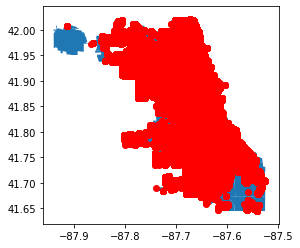

In [9]:
ax = chicago_map.plot()
g_data.plot(ax=ax, color='red')

In [42]:
g_data_names = g_data.groupby('DBA Name').first()
print(len(g_data_names))

27491


In [18]:
middle_lat = g_data_names.Latitude.median()
middle_lon = g_data_names.Longitude.median()
ch_map = folium.Map(location = [middle_lat, middle_lon], zoom_start=10)
locations = folium.map.FeatureGroup()
lats = g_data_names.Latitude
lons = list(g_data_names.Longitude)
names = list(g_data_names.index)


for lat, lon, name in list(zip(lats, lons, names))[0:10]:
    if np.isnan(lat) or np.isnan(lon):
        continue
    folium.Marker(
        location =  [lat, lon],
        tooltip = name,
        icon = folium.Icon(color='red', icon='info-sign')
    ).add_to(ch_map)
    
ch_map.add_child(locations)
ch_map

In [59]:
g_json = g_data.to_json()
g_json = json.loads(g_json)
g_json_data = json.dumps(g_json)